In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MODELPATH = '/content/gdrive/My Drive/Colab Notebooks/yai7_CV1/modelsave/'

IMAGEWOOFPATH = '/content/gdrive/My Drive/Colab Notebooks/data/imagewoof2'

labels = dict(
  n02093754='Australian terrier', 
  n02089973='Border terrier', 
  n02099601='Samoyed',
  n02087394='Beagle', 
  n02105641='Shih-Tzu', 
  n02096294='English foxhound', 
  n02088364='Rhodesian ridgeback', 
  n02115641='Dingo', 
  n02111889='Golden retriever', 
  n02086240='Old English sheepdog'
)

Mounted at /content/gdrive


In [ ]:
# going to use imagewoof dataset for training VGG net D 16

# brief note on VGG 16 architecture :

# seems like there is no batch normalisation
# all hidden layers "equipped" with ReLU
# dropout on first two layers of fully connected layers (p=0.5)
# L2 regularizer
# mini-batch gradient descent with momentum (batchsize=256) (based on LeNet)
# initial learning rate 10^-2
# learning rate decreased fater of 10 when val acc stop improving (ReduceLRonPlateau?)
# 370K iterations = 74 epochs
# augmentations : randomcrop, horizontalflip, randomrgbcolorshift
# shallow train net A first and then do transfer learning?
# random initialization with zero mean 10-^2 variance

##################################
# net A arch:   ## net D arch:   #
#               ##               #
# input 224x224 ## input 224x224 #
#               ##               #
# conv3-64      ## conv3-64      #
#               ## conv3-64      #
# maxpool       ## maxpool       #
#               ##               #
# conv3-128     ## conv3-128     #
#               ## conv3-128     #
# maxpool       ## maxpool       #
#               ##               #
# conv3-256     ## conv3-256     #
# conv3-256     ## conv3-256     #
#               ## conv3-256     #
# maxpool       ## maxpool       #
#               ##               #
# conv3-512     ## conv3-512     #
# conv3-512     ## conv3-512     #
#               ## conv3-512     #
# maxpool       ## maxpool       #
#               ##               #
# conv3-512     ## conv3-512     #
# conv3-512     ## conv3-512     #
#               ## conv3-512     #
# maxpool       ## maxpool       #
#               ##               #
# dropout       ## dropout       #
# fc-4096       ## fc-4096       #
# dropout       ## dropout       #
# fc-4096       ## fc-4096       #
# fc-1000       ## fc-1000       #
# softmax       ## softmax       #
##################################

In [ ]:
import torch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
torch.__version__

'1.7.0+cu101'

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print("check device:", torch.cuda.get_device_name())
print("how many?:", torch.cuda.device_count())
print("so can i use it?", torch.cuda.is_available())

check device: Tesla P100-PCIE-16GB
how many?: 1
so can i use it? True


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# before loading data,
# need to determine transformation (augmentation)

In [ ]:
# no augmentation yet

"""train_transform = A.Compose([
                             ToTensor()
])

test_transform = A.Compose([
                            ToTensor()
])"""

'train_transform = A.Compose([\n                             ToTensor()\n])\n\ntest_transform = A.Compose([\n                            ToTensor()\n])'

In [ ]:
# no need to do this again :)

"""train_transform = transforms.Compose([
                             transforms.Resize(224),
                             transforms.CenterCrop(224),
                             transforms.ToTensor()
])

train_set = torchvision.datasets.ImageFolder(root=IMAGEWOOFPATH+'/train', transform=train_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=False, num_workers=4)"""


"""# page 2
# "The only preprocessing we do is subtracting the mean RGB value, 
# computed on the training set, from each pixel."

mean = 0.
std = 0.
nb_samples = 0.

for data, _ in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'mean = {mean}')
print(f'std = {std}')

del train_set, train_transform, train_loader"""

'# page 2\n# "The only preprocessing we do is subtracting the mean RGB value, \n# computed on the training set, from each pixel."\n\nmean = 0.\nstd = 0.\nnb_samples = 0.\n\nfor data, _ in train_loader:\n    batch_samples = data.size(0)\n    data = data.view(batch_samples, data.size(1), -1)\n    mean += data.mean(2).sum(0)\n    std += data.std(2).sum(0)\n    nb_samples += batch_samples\n\nmean /= nb_samples\nstd /= nb_samples\n\nprint(f\'mean = {mean}\')\nprint(f\'std = {std}\')\n\ndel train_set, train_transform, train_loader'

In [ ]:
# using torchvision transformation
# augmentations : randomcrop, horizontalflip, randomrgbcolorshift
# image for CIFAR10 is too small for randomcrop... so add padding
# paper doesn't say anything about normalization ... so not doing it :P

train_transform = transforms.Compose([
                             transforms.Resize(224),
                             transforms.CenterCrop(224),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

test_transform = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

In [ ]:
train_set = torchvision.datasets.ImageFolder(root=IMAGEWOOFPATH+'/train', transform=train_transform)

test_set = torchvision.datasets.ImageFolder(root=IMAGEWOOFPATH+'/val', transform=test_transform)

# how to retrieve image without using DataLoader?
# just by indexing is good enough

In [ ]:
# checking on the loaded data :0
train_set

Dataset ImageFolder
    Number of datapoints: 9025
    Root location: /content/gdrive/My Drive/Colab Notebooks/data/imagewoof2/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
           )

In [ ]:
test_set

Dataset ImageFolder
    Number of datapoints: 3929
    Root location: /content/gdrive/My Drive/Colab Notebooks/data/imagewoof2/val
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
           )

In [ ]:
labels = dict(
  n02093754='Australian terrier', 
  n02089973='Border terrier', 
  n02099601='Samoyed', 
  n02087394='Beagle', 
  n02105641='Shih-Tzu', 
  n02096294='English foxhound', 
  n02088364='Rhodesian ridgeback', 
  n02115641='Dingo', 
  n02111889='Golden retriever', 
  n02086240='Old English sheepdog'
)

classes = ('Australian terrier', 'Border terrier', 'Samoyed', 'Beagle', 
           'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 
           'Dingo', 'Golden retriever', 'Old English sheepdog')

In [ ]:
# from dataset to loader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

# seems like num_workers works best when...
# num_workers = num GPU * 4 

In [ ]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


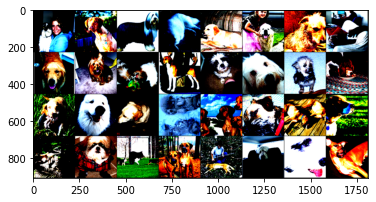

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
# used for checking if image came out with batchsize=1

"""for image, label in train_loader:
    print(image)
    print(image.dtype)
    print(label)
    print(label.dtype)
    print(image.squeeze_().shape)
    imshow(image)
    break"""

'for image, label in train_loader:\n    print(image)\n    print(image.dtype)\n    print(label)\n    print(label.dtype)\n    print(image.squeeze_().shape)\n    imshow(image)\n    break'

In [ ]:
# construct architecture for VGG-D
# but will use this for VGG-A :)

class VGGa(nn.Module):
    def __init__(self):
        super(VGGa, self).__init__()

        self.conv1a = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv1d = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv2a = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv2d = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv3a = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU())
        
        self.conv3d = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.conv4a = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
            )
        self.conv4d = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv5a = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )
        self.conv5d = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # 224 --> 112 --> 56 54 52 --> 26 24 22--> 11 9 7 --> 3
        # 512 * 3 * 3 = 4608
        self.fcd = nn.Linear(4608, 10)


        self.fca = nn.Linear(4608, 10)

        self.dropout = nn.Dropout(p=0.5)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.softmax = nn.Softmax(dim=0)


    def forward(self, x):
        x = self.conv1a(x)
        x = self.maxpool(x)
        x = self.conv2a(x)
        x = self.maxpool(x)
        x = self.conv3a(x)
        x = self.maxpool(x)
        x = self.conv4a(x)
        x = self.maxpool(x)
        x= self.conv5a(x)
        x = self.maxpool(x)
        #print('before view', x.shape)

        # 224 --> 112 --> 56 54 52 --> 26 24 22--> 11 9 7 --> 3
        # 512 * 3 * 3 = 4608
        x = x.view(-1, 4608)
        #print('after view', x.shape)
        x = self.dropout(x)
        x = self.fca(x)
        #x = self.softmax(x)
        return x

In [ ]:
vgga = VGGa()
vgga.to(device)

VGGa(
  (conv1a): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv1d): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2a): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2d): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3a): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv3d): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4a): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv4d): Sequential(
    (0)

In [ ]:
# as in the paper,
# init weights with normal distribution
# init biases with zeros

# init all weights and biases

# next time try making this inside the module

def init_weights(m):

    for i, child in enumerate(m.children()):
        if type(child) is (nn.Linear or nn.Conv2d):
            torch.nn.init.normal_(child.weight, mean=0.0, std=0.01)
            torch.nn.init.zeros_(child.bias)
        elif type(child) == nn.Sequential:
            for j, grandchild in enumerate(child.children()):
                #print(j, grandchild)
                if type(child) is (nn.Linear or nn.Conv2d):
                    torch.nn.init.normal_(grandchild.weight, mean=0.0, std=0.01)
                    torch.nn.init.zeros_(grandchild.bias)

In [ ]:
# try xavier just for fun~
"""
def init_weights(m):

    for i, child in enumerate(m.children()):
        if type(child) is (nn.Linear or nn.Conv2d):
            torch.nn.init.xavier_normal_(child.weight)
            torch.nn.init.zeros_(child.bias)
        elif type(child) == nn.Sequential:
            for j, grandchild in enumerate(child.children()):
                #print(j, grandchild)
                if type(child) is (nn.Linear or nn.Conv2d):
                    torch.nn.init.xavier_normal_(grandchild.weight)
                    torch.nn.init.zeros_(grandchild.bias)"""

'\ndef init_weights(m):\n\n    for i, child in enumerate(m.children()):\n        if type(child) is (nn.Linear or nn.Conv2d):\n            torch.nn.init.xavier_normal_(child.weight)\n            torch.nn.init.zeros_(child.bias)\n        elif type(child) == nn.Sequential:\n            for j, grandchild in enumerate(child.children()):\n                #print(j, grandchild)\n                if type(child) is (nn.Linear or nn.Conv2d):\n                    torch.nn.init.xavier_normal_(grandchild.weight)\n                    torch.nn.init.zeros_(grandchild.bias)'

In [ ]:
init_weights(vgga)

In [ ]:
# just for checking if initialized correctly

"""for i, child in enumerate(vgga.children()):
    if type(child) == nn.Sequential:
        for j, grandchild in enumerate(child.children()):
            if type(child) is (nn.Linear or nn.Conv2d):
                print(i, j, grandchild)
                print(grandchild.weight)
                print(grandchild.bias)

    else:
        if type(child) is (nn.Linear or nn.Conv2d):
            print(i, child)
            print(child.weight)
            print(child.bias)"""

# seems to work :)

'for i, child in enumerate(vgga.children()):\n    if type(child) == nn.Sequential:\n        for j, grandchild in enumerate(child.children()):\n            if type(child) is (nn.Linear or nn.Conv2d):\n                print(i, j, grandchild)\n                print(grandchild.weight)\n                print(grandchild.bias)\n\n    else:\n        if type(child) is (nn.Linear or nn.Conv2d):\n            print(i, child)\n            print(child.weight)\n            print(child.bias)'

In [ ]:
# load pretrained model

epoch = 48

vgga.load_state_dict(torch.load(MODELPATH+f'woof_pretrained_{epoch}_epochs', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
# create vgg-d from VGGA() :)

vggd = nn.Sequential(
    vgga.conv1a,
    vgga.conv1d,
    vgga.maxpool,
    vgga.conv2a,
    vgga.conv2d,
    vgga.maxpool,
    vgga.conv3a,
    vgga.conv3d,
    vgga.maxpool,
    vgga.conv4a,
    vgga.conv4d,
    vgga.maxpool,
    vgga.conv5a,
    vgga.conv5d,
    vgga.maxpool,
    nn.Flatten(),
    vgga.dropout,
    vgga.fcd
)

vggd.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (7): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

In [ ]:
def train_one_epoch(model, train_loader, loss_function, optimizer, epoch):
    #model.train()
    length = len(train_loader)
    #pbar = tqdm(enumerate(train_loader), total=length)
    running_loss = 0.0

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        pred = model(image)
        #print('pred')
        #print(pred.shape)
        #print('label')
        #print(label.shape)
        loss = loss_function(pred, label)
        #print(loss)
        #print(loss.item())
    
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*32} images, running_loss is {running_loss/(i+1):.4f}')
        #pbar.set_description(f'running_loss {running_loss/(i+1):.4f}')

    print(f'epoch {epoch} : loss {running_loss/length:.4f}')


def eval_one_epoch(model, test_loader, scheduler, epoch, best_val_acc):
    #model.eval()
    length = len(test_loader)
    #pbar = tqdm(enumerate(test_loader), total=length)
    running_acc = 0.0

    for i, (image, label) in enumerate(test_loader):
        image, label = image.to(device), label.numpy()

        pred = model(image)
        pred_label = pred.argmax(axis=1).detach().cpu().numpy()
        running_acc += (pred_label==label).mean()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*32} images, running_acc is {running_acc/(i+1):.4f}')
        #pbar.set_description(f'running_acc {running_acc/(i+1):.4f}')

    val_acc = running_acc/length
    scheduler.step(val_acc)

    print(f'epoch {epoch} : acc {val_acc:.4f}')
    
    if val_acc > best_val_acc:
        print("### saving current model...### \n")
        torch.save(model.state_dict(), MODELPATH+f'woof_aftertrain_{epoch}_epochs')
        best_val_acc = val_acc

    return best_val_acc

In [ ]:
# hyperparameters from paper
# assuming same for pretraining

learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4
epochs = 148

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vggd.parameters(), lr=learning_rate, 
                            momentum=momentum, weight_decay=weight_decay)

# patience=5 chosen arbitrarily
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=10, verbose=True
    )

In [ ]:
best_val_acc = 0.0

for epoch in range(epochs):
    vggd.train()
    train_one_epoch(vggd, train_loader, loss_function, optimizer, epoch)
    vggd.eval()
    best_val_acc = eval_one_epoch(vggd, test_loader, scheduler, epoch, best_val_acc)

after looking at 32 images, running_loss is 2.3058
after looking at 1632 images, running_loss is 2.2999
after looking at 3232 images, running_loss is 2.2820
after looking at 4832 images, running_loss is 2.2417
after looking at 6432 images, running_loss is 2.2169
after looking at 8032 images, running_loss is 2.2007
epoch 0 : loss 2.1920
after looking at 32 images, running_acc is 0.0000
after looking at 1632 images, running_acc is 0.0398
after looking at 3232 images, running_acc is 0.1504
epoch 0 : acc 0.1909
### saving current model...### 

after looking at 32 images, running_loss is 1.9486
after looking at 1632 images, running_loss is 2.1118
after looking at 3232 images, running_loss is 2.1109
after looking at 4832 images, running_loss is 2.0987
after looking at 6432 images, running_loss is 2.0919
after looking at 8032 images, running_loss is 2.0903
epoch 1 : loss 2.0886
after looking at 32 images, running_acc is 0.2188
after looking at 1632 images, running_acc is 0.2347
after looking 

In [ ]:
vgga.conv1a[0].weight